In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
import calendar

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_data = pd.read_csv("./bike-sharing-demand/train.csv")
test_data = pd.read_csv("./bike-sharing-demand/test.csv")
submission = pd.read_csv("./bike-sharing-demand/sampleSubmission.csv")

In [3]:
"""
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
holiday - whether the day is considered a holiday
workingday - whether the day is neither a weekend nor holiday
weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
temp - temperature in Celsius
atemp - "feels like" temperature in Celsius
humidity - relative humidity
windspeed - wind speed
casual - number of non-registered user rentals initiated
registered - number of registered user rentals initiated
count - number of total rentals
"""


'\nseason -  1 = spring, 2 = summer, 3 = fall, 4 = winter \nholiday - whether the day is considered a holiday\nworkingday - whether the day is neither a weekend nor holiday\nweather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy\n2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist\n3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds\n4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog \ntemp - temperature in Celsius\natemp - "feels like" temperature in Celsius\nhumidity - relative humidity\nwindspeed - wind speed\ncasual - number of non-registered user rentals initiated\nregistered - number of registered user rentals initiated\ncount - number of total rentals\n'

In [4]:
print(train_data.columns)

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')


In [5]:
train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [7]:
#train_data['date'] = train_data['datetime'].apply(lambda x : x.split()[0])

train_data['year'] = train_data['datetime'].apply(lambda x : x.split()[0].split('-')[0])
train_data['month'] = train_data['datetime'].apply(lambda x : x.split()[0].split('-')[1])
train_data['day'] = train_data['datetime'].apply(lambda x : x.split()[0].split('-')[2])
train_data['hour'] = train_data['datetime'].apply(lambda x : x.split()[1].split(':')[0])
train_data['minute'] = train_data['datetime'].apply(lambda x : x.split()[1].split(':')[1])
train_data['second'] = train_data['datetime'].apply(lambda x : x.split()[1].split(':')[2])

In [8]:
# 요일 피처를 문자로 구현
train_data['date'] = train_data['datetime'].apply(lambda x: x.split()[0])

train_data['weekday'] = train_data['date'].apply(
    lambda dateString: calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])

In [9]:
# season 피처를 범주형 데이터에서 object타입으로 매핑
train_data['season'] = train_data['season'].map({1:'Spring', 2:'Summer',3:'Fall',4:'Winter'})

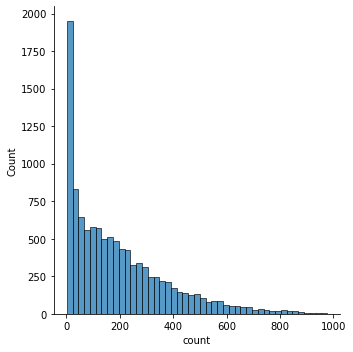

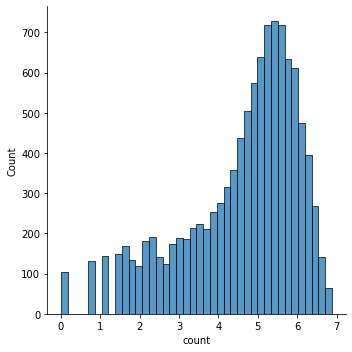

In [10]:
sns.displot(train_data['count'])
sns.displot(np.log(train_data['count']))

# 분포도가 왼쪽으로 편향되어 있기 때문에 회귀 모델에서 좋은 성능을 내기 어렵다. 
# 회귀 모델이 좋은 성능을 내려면 데이터가 정규분포를 따라야 한다. 

In [11]:
count_mean = round(train_data['count'].mean(),1)
count_std = round(train_data['count'].std())

print(count_mean, count_std)

tmp_train_count = (train_data['count']-count_mean)/count_std

191.6 181


In [12]:
# 이상치 제거
train_data = train_data[train_data['weather'] != 4]

In [13]:
# 모델링을 위해 train,test 데이터를 합친 뒤 변환해 주고 다시 나눠준다.
all_data = pd.concat([train_data, test_data] , ignore_index=True)

In [14]:
all_data['year'] = all_data['datetime'].apply(lambda x : x.split()[0].split('-')[0])
all_data['month'] = all_data['datetime'].apply(lambda x : x.split()[0].split('-')[1])
all_data['day'] = all_data['datetime'].apply(lambda x : x.split()[0].split('-')[2])
all_data['hour'] = all_data['datetime'].apply(lambda x : x.split()[1].split(':')[0])
all_data['minute'] = all_data['datetime'].apply(lambda x : x.split()[1].split(':')[1])
all_data['second'] = all_data['datetime'].apply(lambda x : x.split()[1].split(':')[2])

all_data['date'] = all_data['datetime'].apply(lambda x: x.split()[0])
all_data['weekday'] = all_data['date'].apply(
    lambda dateString: calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])

In [15]:
# 필요 없는 colum 제거

drop_colums = ['casual', 'registered', 'datetime', 'date','windspeed','month','day', 'minute','second']
all_data = all_data.drop(drop_colums, axis=1)


In [16]:
weekday_type = all_data['weekday'].unique()
weekday_type

array(['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday'], dtype=object)

In [17]:
all_data['weekday'] = all_data['weekday'].map({'Monday':1, 'Tuesday':2,'Wednesday':3, 'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7})

In [18]:
X_train = all_data[~pd.isnull(all_data['count'])]
X_test = all_data[pd.isnull(all_data['count'])]

In [19]:
target = X_train['count']
X_train = X_train.drop(['count'], axis=1)
X_train['season'] = X_train['season'].map({'Spring':1, 'Summer':2, 'Fall':3, 'Winter':4})
X_test = X_test.drop(['count'], axis=1)

In [20]:
def RMSLE(y_true, y_pred, convertExp=True):
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
        
    log_true = np.nan_to_num(np.log(y_true+1))
    log_pred = np.nan_to_num(np.log(y_pred+1))
    
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output

In [21]:
X_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,2011,00,6
1,1,0,0,1,9.02,13.635,80,2011,01,6
2,1,0,0,1,9.02,13.635,80,2011,02,6
3,1,0,0,1,9.84,14.395,75,2011,03,6
4,1,0,0,1,9.84,14.395,75,2011,04,6


In [22]:
"""# 모델 생성
from sklearn.linear_model import LinearRegression
Linear_model = LinearRegression()

log_target = np.log(target)
Linear_model.fit(X_train,log_target)
preds = Linear_model.predict(X_train)

print("선형회귀 모델 RMSLE값: {:.4f}".format(RMSLE(log_target,preds,True)))
"""


'# 모델 생성\nfrom sklearn.linear_model import LinearRegression\nLinear_model = LinearRegression()\n\nlog_target = np.log(target)\nLinear_model.fit(X_train,log_target)\npreds = Linear_model.predict(X_train)\n\nprint("선형회귀 모델 RMSLE값: {:.4f}".format(RMSLE(log_target,preds,True)))\n'

In [30]:
from sklearn.ensemble import RandomForestRegressor

log_target = np.log(target)
rf_model = RandomForestRegressor(n_estimators=140, max_depth=30, random_state=42)
rf_model.fit(X_train, log_target)
y_pred = rf_model.predict(X_train)

print("랜덤포리스트 모델 RMSLE값: {:.4f}".format(RMSLE(log_target,y_pred,True)))

랜덤포리스트 모델 RMSLE값: 0.1126


In [31]:
X_test

,season,holiday,workingday,weather,temp,atemp,humidity,year,hour,weekday
10885,1,0,1,1,10.66,11.365,56,2011,00,4
10886,1,0,1,1,10.66,13.635,56,2011,01,4
10887,1,0,1,1,10.66,13.635,56,2011,02,4
10888,1,0,1,1,10.66,12.880,56,2011,03,4
10889,1,0,1,1,10.66,12.880,56,2011,04,4
...,...,...,...,...,...,...,...,...,...,...
17373,1,0,1,2,10.66,12.880,60,2012,19,1
17374,1,0,1,2,10.66,12.880,60,2012,20,1
17375,1,0,1,1,10.66,12.880,60,2012,21,1
17376,1,0,1,1,10.66,13.635,56,2012,22,1


In [32]:
test_preds = rf_model.predict(X_test)

submission['count'] = np.exp(test_preds)
submission.to_csv('submission.csv', index=False)